In [28]:
### import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
import gym
import os
import random
import sys
from gym import spaces
from gym.utils import seeding
import copy

from scipy.io import loadmat
import pandapower as pp
import pandapower.networks as pn
import pandas as pd 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [29]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          
plt.rc('axes', titlesize=MEDIUM_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)  
plt.rc('legend', fontsize=SMALL_SIZE)   
plt.rc('figure', titlesize=BIGGER_SIZE) 

### Define env: SCE 56 bus distribution system

In [58]:
class VoltageCtrl_nonlinear(gym.Env):
    def __init__(self, pp_net, injection_bus, v0=1, vmax=1.05, vmin=0.95):
        self.network =  pp_net
        self.obs_dim = 1
        self.action_dim = 1
        self.injection_bus = injection_bus
        self.agentnum = len(injection_bus)
        self.v0 = v0 
        self.vmax = vmax
        self.vmin = vmin
        
        self.load0_p = np.copy(self.network.load['p_mw'])
        self.load0_q = np.copy(self.network.load['q_mvar'])

        self.gen0_p = np.copy(self.network.sgen['p_mw'])
        self.gen0_q = np.copy(self.network.sgen['q_mvar'])
        
        self.state = np.ones(self.agentnum, )
    
    def step(self, action): 
        
        done = False 
        
        reward = float(-50*LA.norm(action)**2 -100*LA.norm(np.clip(self.state-self.vmax, 0, np.inf))**2
                       - 100*LA.norm(np.clip(self.vmin-self.state, 0, np.inf))**2)
        
        # state-transition dynamics
        for i in range(len(self.injection_bus)):
            self.network.sgen.at[i+1, 'q_mvar'] = action[i] 

        pp.runpp(self.network, algorithm='bfsw', init = 'dc')
        
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        
        if(np.min(self.state) > 0.9499 and np.max(self.state)< 1.0501):
            done = True
        
        return self.state, reward, done

    
    def step_Preward(self, action, p_action): 
        
        done = False 
        
        reward = float(-50*LA.norm(p_action) -100*LA.norm(np.clip(self.state-self.vmax, 0, np.inf))
                       - 100*LA.norm(np.clip(self.vmin-self.state, 0, np.inf)))
        
        # local reward
        agent_num = len(self.injection_bus)
        reward_sep = np.zeros(agent_num, )
        
        for i in range(agent_num):
            reward_sep[i] = float(-50*LA.norm(p_action[i])**2 -100*LA.norm(np.clip(self.state[i]-self.vmax, 0, np.inf))**2
                           - 100*LA.norm(np.clip(self.vmin-self.state[i], 0, np.inf))**2)              
        
        # state-transition dynamics
        for i in range(len(self.injection_bus)):
            self.network.sgen.at[i+1, 'q_mvar'] = action[i] 

        pp.runpp(self.network, algorithm='bfsw', init = 'dc')
        
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        
        if(np.min(self.state) > 0.95 and np.max(self.state)< 1.05):
            done = True
        
        return self.state, reward, reward_sep, done

    
    def step_load(self, action, load_p, load_q): #state-transition with specific load
        
        done = False 
        
        reward = float(-50*LA.norm(action)**2 -100*LA.norm(np.clip(self.state-self.vmax, 0, np.inf))**2
                       - 100*LA.norm(np.clip(self.vmin-self.state, 0, np.inf))**2)
        
        #adjust power consumption at the load bus
        for i in range(env.agentnum):
            self.network.load.at[i, 'p_mw'] = load_p[i]
            self.network.load.at[i, 'q_mvar'] = load_q[i]
           
        #adjust reactive power inj at the PV bus
        for i in range(env.agentnum):
            self.network.sgen.at[i, 'q_mvar'] = action[i] 

        pp.runpp(self.network, algorithm='bfsw', init = 'dc')
        
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        state_all = self.network.res_bus.vm_pu.to_numpy()
        
        if(np.min(self.state) > 0.9499 and np.max(self.state)< 1.0501):
            done = True
        
        return self.state, state_all, reward, done
    
    def reset(self, seed=1): #sample different initial volateg conditions during training
        np.random.seed(seed)
        senario = np.random.choice([0, 1])
        if(senario == 0):#low voltage 
           # Low voltage
            self.network.sgen['p_mw'] = 0.0
            self.network.sgen['q_mvar'] = 0.0
            self.network.load['p_mw'] = 0.0
            self.network.load['q_mvar'] = 0.0
            
            self.network.sgen.at[1, 'p_mw'] = -0.5*np.random.uniform(2, 5)
            self.network.sgen.at[2, 'p_mw'] = -0.6*np.random.uniform(10, 30)
            self.network.sgen.at[3, 'p_mw'] = -0.3*np.random.uniform(2, 8)
            self.network.sgen.at[4, 'p_mw'] = -0.3*np.random.uniform(2, 8)
            self.network.sgen.at[5, 'p_mw'] = -0.4*np.random.uniform(2, 8)

        elif(senario == 1): #high voltage 
            self.network.sgen['p_mw'] = 0.0
            self.network.sgen['q_mvar'] = 0.0
            self.network.load['p_mw'] = 0.0
            self.network.load['q_mvar'] = 0.0
            
            self.network.sgen.at[1, 'p_mw'] = 0.5*np.random.uniform(2, 10)
            self.network.sgen.at[2, 'p_mw'] = np.random.uniform(5, 40)
            self.network.sgen.at[3, 'p_mw'] = 0.2*np.random.uniform(2, 14)
            self.network.sgen.at[4, 'p_mw'] = 0.4*np.random.uniform(2, 14) 
            self.network.sgen.at[5, 'p_mw'] = 0.4*np.random.uniform(2, 14) 
        
        else: #mixture (this is used only during testing)
            self.network.sgen['p_mw'] = 0.0
            self.network.sgen['q_mvar'] = 0.0
            self.network.load['p_mw'] = 0.0
            self.network.load['q_mvar'] = 0.0
            
            self.network.sgen.at[1, 'p_mw'] = -2*np.random.uniform(2, 3)
            self.network.sgen.at[2, 'p_mw'] = np.random.uniform(15, 35)
            self.network.sgen.at[2, 'q_mvar'] = 0.1*self.network.sgen.at[2, 'p_mw']
            self.network.sgen.at[3, 'p_mw'] = 0.2*np.random.uniform(2, 12)
            self.network.sgen.at[4, 'p_mw'] = -2*np.random.uniform(2, 8) 
            self.network.sgen.at[5, 'p_mw'] = 0.2*np.random.uniform(2, 12) 
            self.network.sgen.at[5, 'q_mvar'] = 0.2*self.network.sgen.at[5, 'p_mw']
            
        
        pp.runpp(self.network, algorithm='bfsw')
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        return self.state
    
    def reset0(self, seed=1): #reset voltage to nominal value
        
        self.network.load['p_mw'] = 0*self.load0_p
        self.network.load['q_mvar'] = 0*self.load0_q

        self.network.sgen['p_mw'] = 0*self.gen0_p
        self.network.sgen['q_mvar'] = 0*self.gen0_q
        
        pp.runpp(self.network, algorithm='bfsw')
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        return self.state

In [59]:
def create_56bus():
    pp_net = pp.converter.from_mpc('data/SCE_56bus.mat', casename_mpc_file='case_mpc')
    
    pp_net.sgen['p_mw'] = 0.0
    pp_net.sgen['q_mvar'] = 0.0

    pp.create_sgen(pp_net, 17, p_mw = 1.5, q_mvar=0)
    pp.create_sgen(pp_net, 20, p_mw = 1, q_mvar=0)
    pp.create_sgen(pp_net, 29, p_mw = 1, q_mvar=0)
    pp.create_sgen(pp_net, 44, p_mw = 2, q_mvar=0)
    pp.create_sgen(pp_net, 52, p_mw = 2, q_mvar=0)
    
    return pp_net

In [60]:
pp_net = create_56bus()
injection_bus = np.array([18, 21, 30, 45, 53])-1  
env = VoltageCtrl_nonlinear(pp_net, injection_bus)

### DDPG Utils

In [61]:
# monotone policy network with dead-band between [v_min, v_max]
class SafePolicyNetwork(nn.Module):
    def __init__(self, env, obs_dim, action_dim, hidden_dim, scale = 0.15, init_w=3e-3):
        super(SafePolicyNetwork, self).__init__()

        self.env = env
        self.hidden_dim = hidden_dim
        self.scale = scale
        
        #define weight and bias recover matrix
        self.w_recover = torch.ones((self.hidden_dim, self.hidden_dim))
        self.w_recover = -torch.triu(self.w_recover, diagonal=0)\
        +torch.triu(self.w_recover, diagonal=2)+2*torch.eye(self.hidden_dim)
        
        self.b_recover = torch.ones((self.hidden_dim, self.hidden_dim))
        self.b_recover = torch.triu(self.b_recover, diagonal=0)-torch.eye(self.hidden_dim)
        
        self.select_w = torch.ones(1, self.hidden_dim)
        self.select_wneg = -torch.ones(1, self.hidden_dim)
        
        # initialization
        self.b = torch.rand(self.hidden_dim)
        self.b = (self.b/torch.sum(self.b))*scale
        self.b = torch.nn.Parameter(self.b, requires_grad=True)
        
        self.c = torch.rand(self.hidden_dim)
        self.c = (self.c/torch.sum(self.c))*scale
        self.c = torch.nn.Parameter(self.c, requires_grad=True)
        
        self.q = torch.nn.Parameter(torch.rand(action_dim, self.hidden_dim), requires_grad=True)
        self.z = torch.nn.Parameter(torch.rand(action_dim, self.hidden_dim), requires_grad=True)
        
    def forward(self, state):
        self.w_plus=torch.matmul(torch.square(self.q), self.w_recover)
        
        self.w_minus=torch.matmul(-torch.square(self.q), self.w_recover)
        
        b = self.b.data
        b = b.clamp(min=0)
        b = self.scale*b/torch.norm(b, 1)
        self.b.data = b
        
        c = self.c.data
        c = c.clamp(min=0)
        c = self.scale*c/torch.norm(c, 1)
        self.c.data = c
        
        self.b_plus=torch.matmul(-self.b, self.b_recover) - torch.tensor(env.vmax)
        self.b_minus=torch.matmul(-self.b, self.b_recover) + torch.tensor(env.vmin)
        
        self.nonlinear_plus = torch.matmul(F.relu(torch.matmul(state, self.select_w)
                                                  + self.b_plus.view(1, self.hidden_dim)),
                                           torch.transpose(self.w_plus, 0, 1))
        
        self.nonlinear_minus = torch.matmul(F.relu(torch.matmul(state, self.select_wneg)
                                                   + self.b_minus.view(1, self.hidden_dim)),
                                            torch.transpose(self.w_minus, 0, 1))
        
        x = (self.nonlinear_plus+self.nonlinear_minus) 
        
        return x

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0] 

In [62]:
# standard ddpg policy network
class PolicyNetwork(nn.Module):
    def __init__(self, env, obs_dim, action_dim, hidden_dim, init_w=3e-3):
        super(PolicyNetwork, self).__init__()

        self.env = env
        self.linear1 = nn.Linear(obs_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, action_dim)

        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state):
        state.requires_grad = True
        x = torch.relu(self.linear1(state))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0]

In [63]:
# value network
class ValueNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        self.linear1 = nn.Linear(obs_dim + action_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

class ReplayBufferPI:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, last_action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, last_action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, last_action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, last_action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [64]:
# DPPG class
class DDPG:
    def __init__(self, policy_net, value_net,
                 target_policy_net, target_value_net,
                 value_lr=2e-4,
                 policy_lr=1e-4):
        
        self.policy_net = policy_net
        self.value_net = value_net
        self.target_policy_net = target_policy_net
        self.target_value_net = target_value_net
        
        self.value_lr = value_lr
        self.policy_lr = policy_lr
        
        self.value_optimizer = optim.Adam(value_net.parameters(),  lr=value_lr)
        self.policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
        self.value_criterion = nn.MSELoss()

    def train_step(self, replay_buffer, batch_size,
                   gamma=0.99,
                   soft_tau=1e-2):

        state, action, last_action, reward, next_state, done = replay_buffer.sample(batch_size)

        state = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action = torch.FloatTensor(action).to(device)
        last_action = torch.FloatTensor(last_action).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

        next_action = action-self.target_policy_net(next_state)    
        target_value = self.target_value_net(next_state, next_action.detach())
        expected_value = reward + gamma*(1.0-done)*target_value
        
        value = self.value_net(state, action)
        value_loss = self.value_criterion(value, expected_value.detach())
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
 
        self.value_optimizer.step()
        
        
        policy_loss = self.value_net(state, last_action-self.policy_net(state))
        policy_loss = -policy_loss.mean()
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data*soft_tau
            )

        for target_param, param in zip(self.target_policy_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [65]:
# plot policy
def plot_policy(policy_net, episode):
    s_array = np.zeros(30,)

    a_array_baseline = np.zeros(30,)
    a_array = np.zeros(30,)
    for i in range(30):
        state = torch.tensor([0.85+0.01*i])
        s_array[i] = state

        action_baseline = -(np.maximum(state-1.05, 0)-np.maximum(0.95-state, 0)).reshape((1,))
        action = -agent_list[3].policy_net(state.reshape(1,1))

        a_array_baseline[i] = action_baseline[0]
        a_array[i] = action[0]
        
    plt.figure() 
    plt.plot(s_array, a_array_baseline, label = 'Baseline')
    plt.plot(s_array, a_array, label = 'RL')
    plt.savefig('Policy{0}.png'.format(episode), dpi=100)

### Train policy

In [66]:
seed = 10
num_agent = 5
obs_dim = env.obs_dim
action_dim = env.action_dim
hidden_dim = 100

"""
Create Agent list and replay buffer
"""

torch.manual_seed(seed)

agent_list = []
replay_buffer_list = []

for i in range(num_agent):
    value_net  = ValueNetwork(obs_dim=obs_dim, action_dim=action_dim, hidden_dim=hidden_dim).to(device)
    policy_net = SafePolicyNetwork(env=env, obs_dim=obs_dim, action_dim=action_dim, hidden_dim=hidden_dim).to(device)

    target_value_net  = ValueNetwork(obs_dim=obs_dim, action_dim=action_dim, hidden_dim=hidden_dim).to(device)
    target_policy_net = SafePolicyNetwork(env=env, obs_dim=obs_dim, action_dim=action_dim, hidden_dim=hidden_dim).to(device)

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(param.data)

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(param.data)

    agent = DDPG(policy_net=policy_net, value_net=value_net,
                 target_policy_net=target_policy_net, target_value_net=target_value_net)
    
    replay_buffer = ReplayBufferPI(capacity=1000000)
    
    agent_list.append(agent)
    replay_buffer_list.append(replay_buffer)

In [97]:
FLAG = 0

if (FLAG ==0): 
    # load trained policy
    valuenet_dict = torch.load('saved_models/stable_ddpg/value_net_checkpoint_a0.pth')
    policynet_dict = torch.load('saved_models/stable_ddpg/policy_net_checkpoint_a0.pth')
    agent_list[0].value_net.load_state_dict(valuenet_dict)
    agent_list[0].policy_net.load_state_dict(policynet_dict)

    valuenet_dict = torch.load('saved_models/stable_ddpg/value_net_checkpoint_a1.pth')
    policynet_dict = torch.load('saved_models/stable_ddpg/policy_net_checkpoint_a1.pth')
    agent_list[1].value_net.load_state_dict(valuenet_dict)
    agent_list[1].policy_net.load_state_dict(policynet_dict)

    valuenet_dict = torch.load('saved_models/stable_ddpg/value_net_checkpoint_a2.pth')
    policynet_dict = torch.load('saved_models/stable_ddpg/policy_net_checkpoint_a2.pth')
    agent_list[2].value_net.load_state_dict(valuenet_dict)
    agent_list[2].policy_net.load_state_dict(policynet_dict)

    valuenet_dict = torch.load('saved_models/stable_ddpg/value_net_checkpoint_a3.pth')
    policynet_dict = torch.load('saved_models/stable_ddpg/policy_net_checkpoint_a3.pth')
    agent_list[3].value_net.load_state_dict(valuenet_dict)
    agent_list[3].policy_net.load_state_dict(policynet_dict)

    valuenet_dict = torch.load('saved_models/stable_ddpg/value_net_checkpoint_a4.pth')
    policynet_dict = torch.load('saved_models/stable_ddpg/policy_net_checkpoint_a4.pth')
    agent_list[4].value_net.load_state_dict(valuenet_dict)
    agent_list[4].policy_net.load_state_dict(policynet_dict)

elif (FLAG ==1):
    # training episode
    num_episodes = 200

    # trajetory length each episode
    num_steps = 30  

    batch_size = 256

    # if/not plot trained policy every # episodes
    plot = False

    rewards = []
    avg_reward_list = []

    for episode in range(num_episodes):
        if(episode%50==0 and plot == True):
            plot_policy(agent_list[3].policy_net, episode)

        state = env.reset(seed = episode)
        episode_reward = 0
        last_action = np.zeros((num_agent,1))

        for step in range(num_steps):
            action = []
            for i in range(num_agent):
                # sample action according to the current policy and exploration noise
                action_agent = agent_list[i].policy_net.get_action(np.asarray([state[i]]))+np.random.normal(0, 0.05)
                action_agent = np.clip(action_agent, -0.3, 0.3)
                action.append(action_agent)

            # PI policy    
            action = last_action - np.asarray(action)

            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env.step_Preward(action, (last_action-action))

            if(np.min(next_state)<0.75): #if voltage violation > 25%, episode ends.
                break
            else:
                for i in range(num_agent): 
                    state_buffer = state[i].reshape(1,)
                    action_buffer = action[i].reshape(1,)
                    last_action_buffer = last_action[i].reshape(1,)
                    next_state_buffer = next_state[i].reshape(1, )

                    # store transition (s_t, a_t, r_t, s_{t+1}) in R
                    replay_buffer_list[i].push(state_buffer, action_buffer, last_action_buffer,
                                               reward, next_state_buffer, done)

                    # update both critic and actor network
                    if len(replay_buffer_list[i]) > batch_size:
                        agent_list[i].train_step(replay_buffer=replay_buffer_list[i], 
                                                 batch_size=batch_size)

                if(done):
                    episode_reward += reward  
                    break
                else:
                    state = np.copy(next_state)
                    episode_reward += reward    

            last_action = np.copy(action)

        rewards.append(episode_reward)
        avg_reward = np.mean(rewards[-40:])
        if(episode%50==0):
            print("Episode * {} * Avg Reward is ==> {}".format(episode, avg_reward))
        avg_reward_list.append(avg_reward)

else:
    raise ValueError("Model loading optition does not exist!")

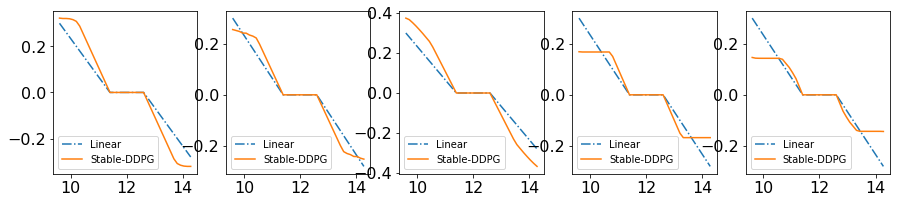

In [98]:
## test policy
title = ['Bus 18', 'Bus 21', 'Bus 30', 'Bus 45', 'Bus 53']

fig, axs = plt.subplots(1, 5, figsize=(15,3))
for i in range(num_agent):
    # plot policy
    N = 40
    s_array = np.zeros(N,)
    
    a_array_baseline = np.zeros(N,)
    a_array = np.zeros(N,)
    
    for j in range(N):
        state = torch.tensor([0.8+0.01*j])
        s_array[j] = state

        action_baseline = (np.maximum(state-1.05, 0)-np.maximum(0.95-state, 0)).reshape((1,))
    
        action = agent_list[i].policy_net.get_action(np.asarray([state]))
        
        a_array_baseline[j] = -action_baseline[0]
        a_array[j] = -action

    axs[i].plot(12*s_array, 2*a_array_baseline, '-.', label = 'Linear')
    axs[i].plot(12*s_array, a_array, label = 'Stable-DDPG')
    axs[i].legend(loc='lower left')

### Test with Simulated Data

In [99]:
pp_net = create_56bus()
injection_bus = np.array([18, 21, 30, 45, 53])-1  
env = VoltageCtrl_nonlinear(pp_net, injection_bus)

In [100]:
state = env.reset(seed=1)
episode_reward = 0
episode_control = 0
num_agent = 5
voltage = []
q = []
cost = []

last_action = np.zeros((num_agent,1))

for t in range(100):
    state1 = np.asarray(state-env.vmax)
    state2 = np.asarray(env.vmin-state)
    d_v = (np.maximum(state1, 0)-np.maximum(state2, 0)).reshape((num_agent,1))
    
    action = (last_action - 10*d_v)
    
    last_action = np.copy(action)
    
    next_state, reward, done = env.step(action)

    voltage.append(state)

    q.append(action)

    state = next_state
    
    episode_reward += reward
    
    cost.append(-reward)
    
    episode_control += LA.norm(action, 2)**2

voltage_baseline = np.asarray(voltage)
q_baseline =  np.asarray(q)
cost_baseline =  np.asarray(cost)

In [101]:
state = env.reset(seed=1)
episode_reward = 0
episode_control = 0
num_agent = 5
voltage = []
q = []
cost = []

last_action = np.zeros((num_agent,1))

for t in range(100):
    action = []
    for i in range(num_agent):
        action_agent = agent_list[i].policy_net.get_action(torch.tensor([state[i]]).float().reshape(1,1))
        action.append(action_agent)
    
    action = last_action - 5*np.asarray(action).reshape((num_agent, 1))
    
    last_action = np.copy(action)
    
    next_state, reward, done = env.step(action)

    voltage.append(state)

    q.append(action)

    state = next_state
    
    episode_reward += reward
    
    cost.append(-reward)
    
    episode_control += LA.norm(action, 2)**2

voltage_RL = np.asarray(voltage)
q_RL =  np.asarray(q)
cost_RL =  np.asarray(cost)

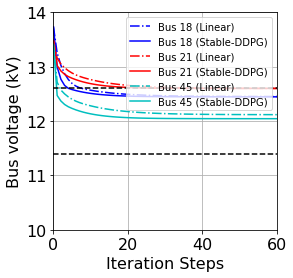

In [102]:
index = [0, 1, 3] 
labels = ['Bus 18 (Linear)', 'Bus 18 (Stable-DDPG)', 
          'Bus 21 (Linear)', 'Bus 21 (Stable-DDPG)',
          'Bus 45 (Linear)', 'Bus 45 (Stable-DDPG)']
colors = ['b', 'r', 'c']

f = plt.figure(figsize=(4, 4))
ax = f.add_subplot(111)

for i in range(len(index)):
    ax.plot(12*voltage_baseline[:, index[i]], '-.', color = colors[i], label = labels[2*i])
    ax.plot(12*voltage_RL[:, index[i]], color = colors[i], label = labels[2*i+1])

ax.legend(loc = 'upper right')
ax.axhline(y=12.6, color='k', linestyle='--', label = 'Upper bound')
ax.axhline(y=11.4, color='k', linestyle='--', label = 'Lower bound')
ax.set_xlim([0, 60])
ax.set_ylim([10, 14])
ax.set_yticks([10, 11, 12, 13, 14])
ax.set_ylabel('Bus voltage (kV)')
ax.set_xlabel('Iteration Steps')
#ax.set_title('Voltage profile')
ax.grid()